# Try artificial neural netwroks on the single cell data (disclaimer: there is still room to improve this notebook)
The correlation analysis performed between the individual feature values (binding affinity score of each TF) and response (gene expression in each cell) showed very minor linear association indicating a non-linear association between feature and response variables. To test this, we decided to train NN models on the same data hoping to improve the single cell gene expression.
There are plenty hyper-parameters that can be tuned in order to train a neural netwrok, such as:
* number of hidden layers,
* number of nodes in each hidden layer,
* activation function used in each layer",
* regularization techniques:
    * dropouts -> tune the dropout rate,
    * L1/L2 norm regularizations -> lambda parameter,
* number of epochs,
* Batch size,
* early stopping patience,
* Ratio for the validation split,
* ..."

## Load the required libraries

In [19]:
library(keras)
library(ggplot2)
library(pheatmap)

## Load the partitioned and normalized data (to save I/O operations)

In [2]:
load("../Stem_Net_normalized_data.RData")

### List of variables in the workspace after loading the data file

In [3]:
print(ls())

[1] "test_x"  "test_y"  "train_x" "train_y" "x"       "y"      


### Dimensions of the training and test data

In [4]:
print("train:")
print(dim(train_x))

print("test:")
print(dim(test_x))

[1] "train:"
[1] 11396   726
[1] "test:"
[1] 2850  726


In [5]:
print(range(train_x))
print(range(train_y))

print(range(test_x))
print(range(test_y))

[1]  -2.919368 106.742666
[1] -0.3497536 55.6022780
[1]   -2.919368 1410.035561
[1] -0.3497536 55.6022780


## Do PCA on the features of training (and test data)

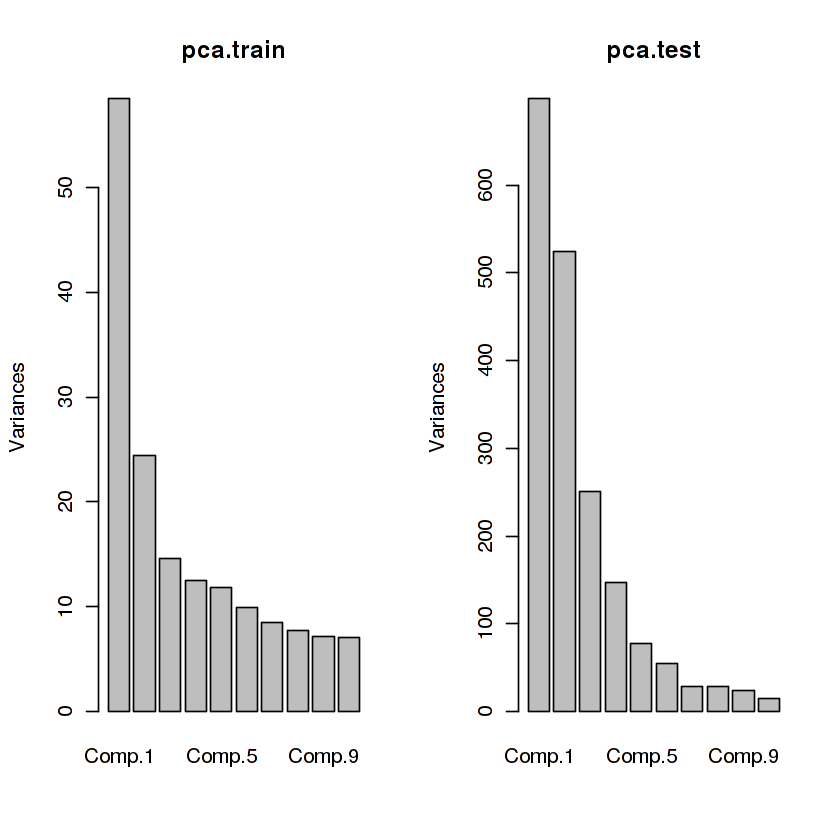

In [6]:
doPCA <- TRUE
if(doPCA){
    pca.train <- princomp(train_x)
    pca.test <- princomp(test_x)
    par(mfrow= c(1, 2))
    plot(pca.train)
    plot(pca.test)
}

## Set the NN hyper-parameters

In [7]:
epochs <- 200
early_stop_patience <- 20
hidden_layer <- 50 #c(floor(mean(ncol(train_x), ncol(train_y))))
#hidden_layer <- c(512, 256, 128)
print("hiddenlayer info:")
print(hidden_layer)
activation_func <- c("tanh") #, "tanh", "tanh")
drop_out_rate <- .01
batch_size <- 16
val_split_ratio <- .2
l1_lambda <- l2_lambda <- .0

[1] "hiddenlayer info:"
[1] 50


## Build the NN model

In [8]:
model <- keras_model_sequential()

# build the 1st layer
layer_dense(model, units= hidden_layer[1], activation= activation_func[1], input_shape= ncol(train_x),
            kernel_regularizer= regularizer_l1_l2(l1= l1_lambda, l2= l2_lambda))
model <- layer_dropout(model, rate= drop_out_rate)

# add the other hidden layers
if(length(hidden_layer) > 1){
    for(i in seq(2, length(hidden_layer))){
        model <- layer_dense(model, units= hidden_layer[i], activation= activation_func[i],
                          kernel_regularizer= regularizer_l1_l2(l1= l1_lambda, l2= l2_lambda))
        model <- layer_dropout(model, rate= drop_out_rate)
    }
}

# finish off by adding the output layer
model <- layer_dense(model, units= ncol(train_y), activation = "relu")

## Compile the model

In [9]:
compile(model, loss= "mse", optimizer= optimizer_rmsprop(), metrics= list("mean_absolute_error"))

## Summary of the model

In [10]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 50)                      36350       
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 50)                      0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 621)                     31671       
Total params: 68,021
Trainable params: 68,021
Non-trainable params: 0
________________________________________________________________________________


## Fit the data to the built and compiled model

In [11]:
early_stop <- callback_early_stopping(monitor= "val_loss", patience= early_stop_patience)
remote_monitor <- callback_remote_monitor(root= 'http://localhost:8888', path='/publish/epoch/end/', field= 'data', headers= NULL, send_as_json= F)

history <- fit(model, as.matrix(train_x), as.matrix(train_y), 
               epochs= epochs, batch_size= batch_size, validation_split= val_split_ratio,
               verbose= 1, callback= list(early_stop))


## Model performance per epoch

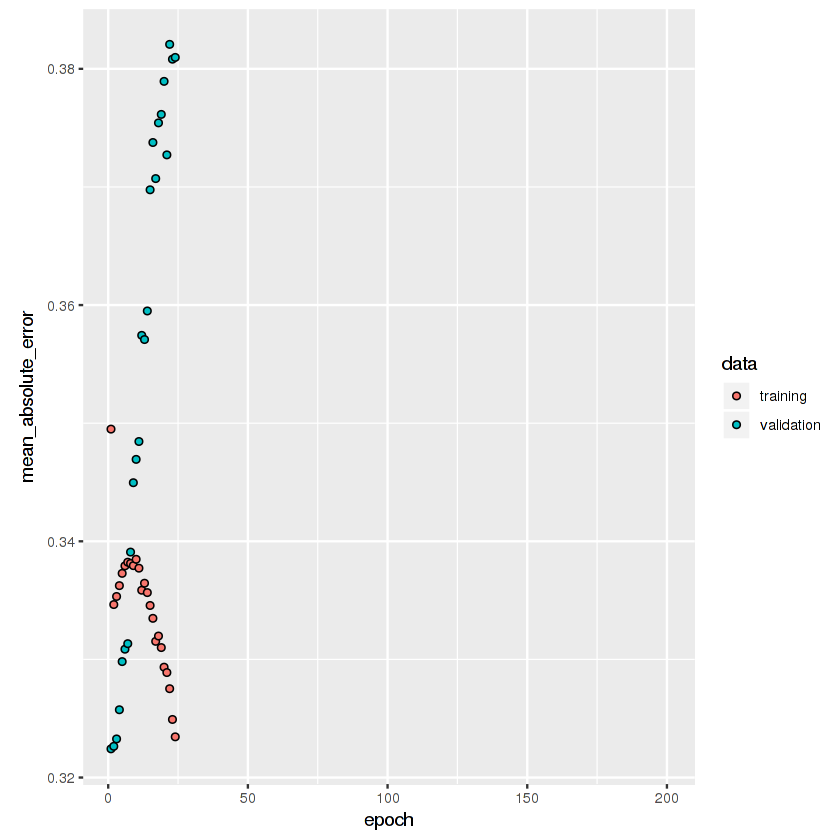

In [12]:
plot(history, metrics = "mean_absolute_error", smooth = FALSE)

## Predict the response

In [13]:
pred.train <- predict(model, as.matrix(train_x))
pred.test <- predict(model, as.matrix(test_x))

## Plot the response (perdicted and measured) on the test data (training is a lot to show)

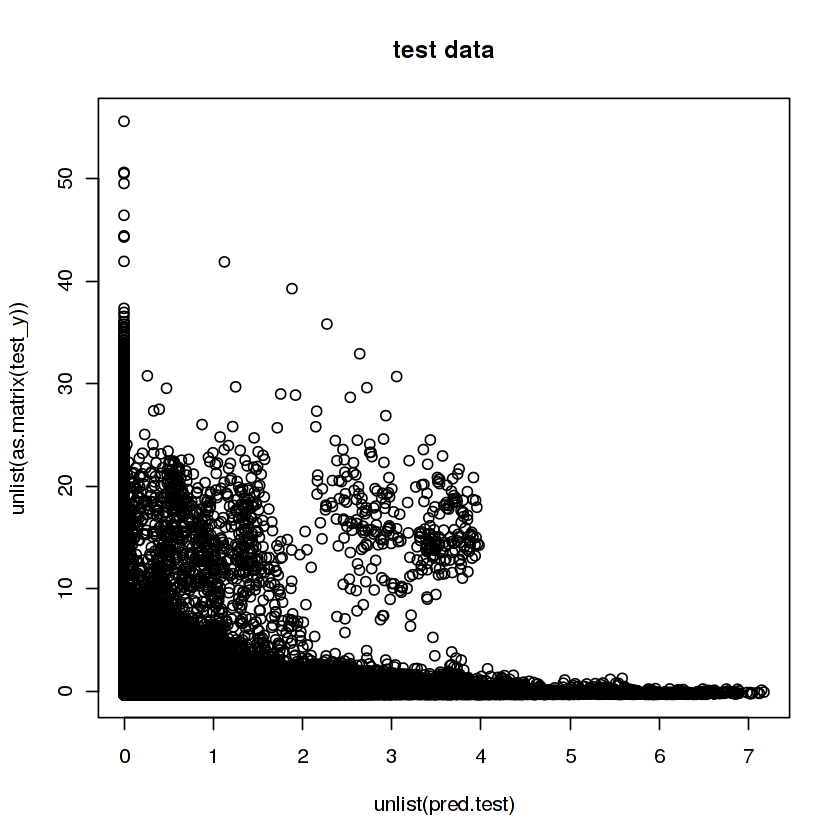

In [14]:
plot(unlist(pred.test), unlist(as.matrix(test_y)), main= "test data")

## Compute the correlation between the actual response and the predicted

In [15]:
cors.train <- sapply(seq(ncol(pred.train)), function(i) cor(pred.train[, i], train_y[, i]))
cors.test <- sapply(seq(ncol(pred.test)), function(i) cor(pred.test[, i], test_y[, i]))

Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], tra

“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.train[, i], train_y[, i]):
“the standard deviation is zero”Warning mes

“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[, i], test_y[, i]):
“the standard deviation is zero”Warning message in cor(pred.test[

## Plot the correlation histograms

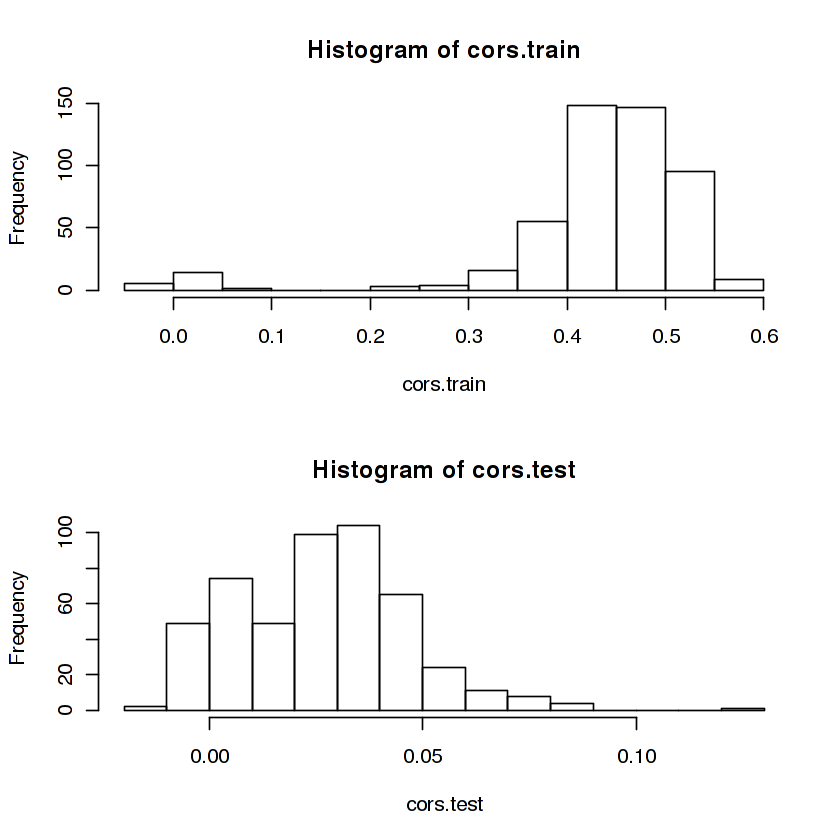

In [16]:
par(mfrow= c(2, 1))
 hist(cors.train)
 hist(cors.test)

## Get model weights

In [17]:
model_weights <- get_weights(model)
print(length(model_weights))

[1] 4


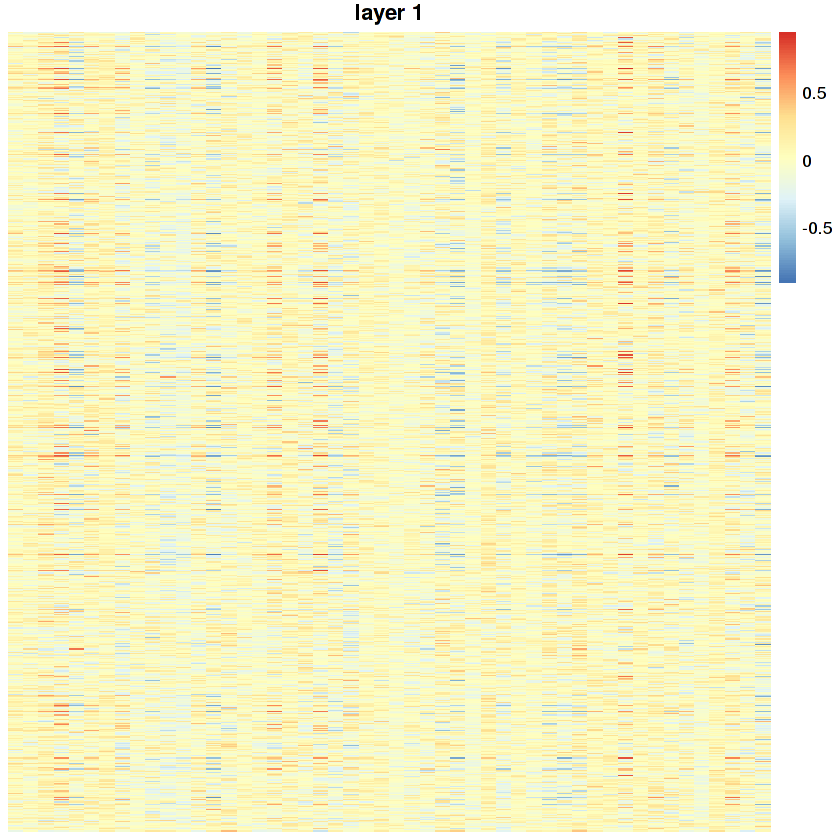

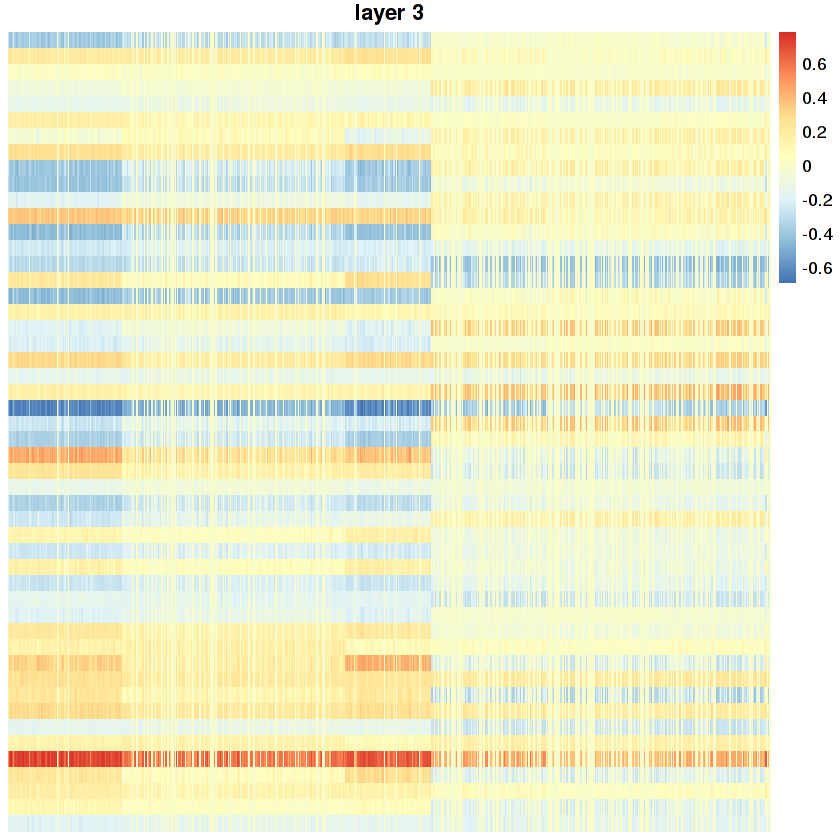

In [18]:
for(i in seq(1, length(model_weights), by= 2)) # Skipping the bias weights
    pheatmap(model_weights[[i]], cluster_rows= F, cluster_cols= F, main= paste("layer", i))

# Conclusion

* We do see a very bad over-fitting of the NN model. I had tried adding the L1 nad L2 regulaziers, but they just fixate the error on a constant value (pretty strange). This sort of only suggests that there is really no real signal in the data to be learnt and whatever the model has picked up in the training phase was noise, which of course is not generalizable on the test data.
* Here we didn't impute the data. One could try this with the imputed TPM values (now that I have generated them, should be pretty simple).
* I had played around a bit with the architecture as well, but I think the major problem is coming from the data quality itself.